# Region-Based Hierarchical Clustering Color Quantization (RHCCQ)

## Introduction

RHCCQ is an adaptive image compression system that prioritizes visual quality in important regions while aggressively compressing less significant areas. Unlike standard compression methods, RHCCQ uses ROI detection to identify critical image regions and applies hierarchical color clustering to reduce colors without losing important details.

## How It Works

1. **ROI Detection**: Identifies important regions using edge density analysis
2. **Region Segmentation**: Divides image into ROI (high quality) and non-ROI (low quality)
3. **Hierarchical Clustering**: Groups similar colors while preserving important variations
4. **Matrix Encoding**: Stores compressed color indices and optimized color palettes
5. **File Output**: Creates .rhccq files with region information and compressed data

## Technical Advantages

- **Better Detail Preservation**: Hierarchical clustering reduces color banding artifacts
- **Adaptive Bit Allocation**: More bits allocated to important regions
- **Configurable Trade-offs**: Users balance quality vs. compression based on application needs
- **Novel Approach**: Combines ROI awareness with advanced color quantization


## Methodology
The following code shows the whole process of the compression by using a famous image for Image Processing

In [12]:
# Helper Functions to plot

import matplotlib.pyplot as plt

def plot_border_stages(intensity_borders, binary_borders, 
                       binary_thin_bordersless, noiseless_binary_borders,
                       pre_connected, connected, figsize=(16, 10)):
    """
    Plot all border processing stages in a 2x3 grid.
    """
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # Flatten axes for easy indexing
    axes = axes.flatten()
    
    # Plot each image with appropriate colormap
    images = [
        (intensity_borders, "Intensity Borders", "gray"),
        (binary_borders, "Binary Borders", "gray"),
        (binary_thin_bordersless, "Thinned Borders", "gray"),
        (noiseless_binary_borders, "Noiseless Borders", "gray"),
        (pre_connected, "Pre-Connected", "gray"),
        (connected, "Final Connected", "gray")
    ]
    
    for ax, (img, title, cmap) in zip(axes, images):
        # Handle binary vs intensity images
        if img.dtype == bool or img.max() == 1:
            ax.imshow(img, cmap=cmap, vmin=0, vmax=1)
        else:
            ax.imshow(img, cmap=cmap)
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Add image stats
        if img.dtype == bool:
            stats = f"True: {img.sum():,}\nFalse: {(~img).sum():,}"
        else:
            stats = f"Min: {img.min():.1f}\nMax: {img.max():.1f}\nMean: {img.mean():.3f}"
        
        # Add stats in top-left corner
        ax.text(0.02, 0.98, stats,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle("Border Processing Pipeline", fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_region_processing_pipeline(denoised, border_mask, protected_image, 
                                   bridged_image, closed_regions, cleaned_image, 
                                   region_map, figsize=(18, 10)):
    """
    Plot the region processing pipeline in a 3x3 grid (with one empty spot).
    """
    # Create subplots - 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    
    # Images and their titles
    images = [
        denoised,
        border_mask,
        protected_image,
        bridged_image,
        closed_regions,
        cleaned_image,
        region_map
    ]
    
    titles = [
        "1. Denoised Borders",
        "2. Border Mask", 
        "3. Protected Image",
        "4. Bridged Gaps",
        "5. Morphologically Closed",
        "6. Cleaned Regions",
        "7. Final Region Map"
    ]
    
    descriptions = [
        "Noise removed from binary borders",
        "Mask of detected border pixels",
        "Original image with border protection",
        "Small gaps bridged for connectivity",
        "After morphological closing operations",
        "Small regions filtered out",
        "Final ROI (white) / non-ROI (black) map"
    ]
    
    # Plot each image
    for idx, (img, title, desc) in enumerate(zip(images, titles, descriptions)):
        row = idx // 3
        col = idx % 3
        
        ax = axes[row, col]
        
        # Choose colormap based on content
        if 'region map' in title.lower() or 'mask' in title.lower():
            # Binary/border images
            if img.dtype == bool:
                ax.imshow(img, cmap='gray_r', vmin=0, vmax=1)  # gray_r for white=borders
            else:
                ax.imshow(img, cmap='gray_r')
        elif 'image' in title.lower():
            # Color images
            if len(img.shape) == 3 and img.shape[2] == 3:
                ax.imshow(img)
            else:
                ax.imshow(img, cmap='gray')
        else:
            # Default to grayscale
            ax.imshow(img, cmap='gray')
        
        ax.set_title(title, fontsize=12, fontweight='bold', color='darkgreen')
        ax.axis('off')
        
        # Add statistics
        stats_text = f"{desc}\n\n"
        
        if img.dtype == bool or np.max(img) <= 1:
            # Binary image stats
            true_count = np.sum(img)
            total_pixels = img.size
            percentage = (true_count / total_pixels) * 100
            
            if 'region' in title.lower():
                stats_text += f"ROI: {true_count:,} px\n"
                stats_text += f"({percentage:.1f}% of image)"
            else:
                stats_text += f"Edges: {true_count:,} px\n"
                stats_text += f"({percentage:.2f}%)"
        elif len(img.shape) == 2:
            # Grayscale image stats
            stats_text += f"Range: [{img.min():.0f}, {img.max():.0f}]\n"
            stats_text += f"Mean: {img.mean():.1f}"
        else:
            # Color image stats
            stats_text += f"Shape: {img.shape}"
        
        # Add stats box
        ax.text(0.02, 0.98, stats_text,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Hide the last two empty subplots (8th and 9th)
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    
    plt.suptitle("Region Processing Pipeline - From Borders to ROI Map", 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()



### Loading of the Image

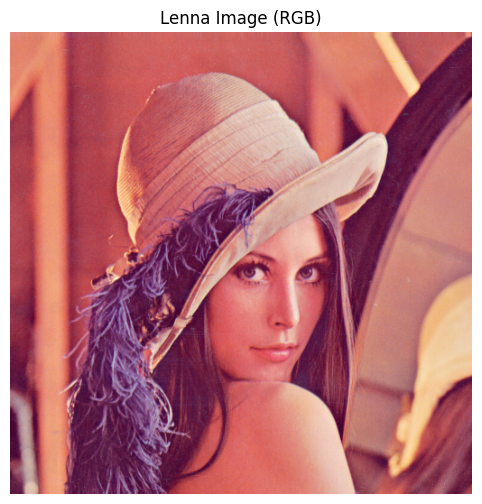

In [3]:
import cv2

image_name = "images/png/Lenna.png"
image = cv2.imread(image_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


import matplotlib.pyplot as plt

# Display the image
plt.figure(figsize=(8, 6))  # Optional: Set figure size
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.title("Lenna Image (RGB)")
plt.show()

### Region of Interest Detection

density_map: 0.009 seconds
connected: 0.002 seconds
thin_regions_mask: 0.009 seconds
Removed 1395 pixels from 30 thin regions in low-density areas




density_map: 0.006 seconds
Removed 186 small components in low-density areas
Preserved 745 small components in dense areas
denoised_white: 0.008 seconds
Removed 2 small components in low-density areas
Preserved 16 small components in dense areas
denoised_black: 0.010 seconds
Bridged 36517 internal gap pixels


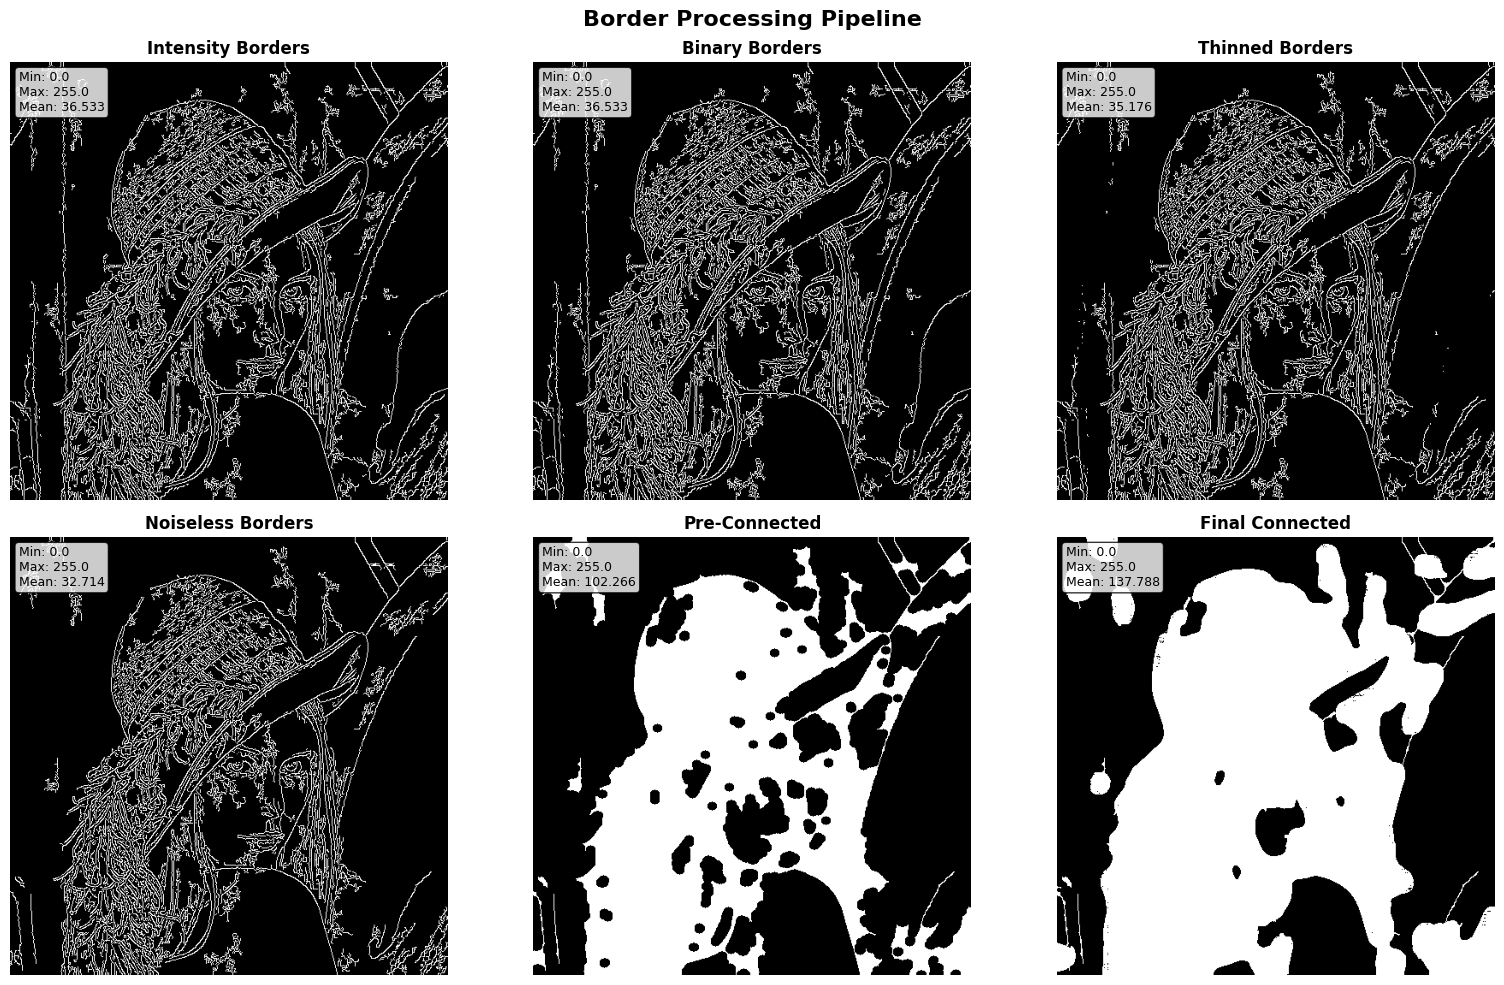

Bridged 629 internal gap pixels
Filled 73 pixels in 4 holes


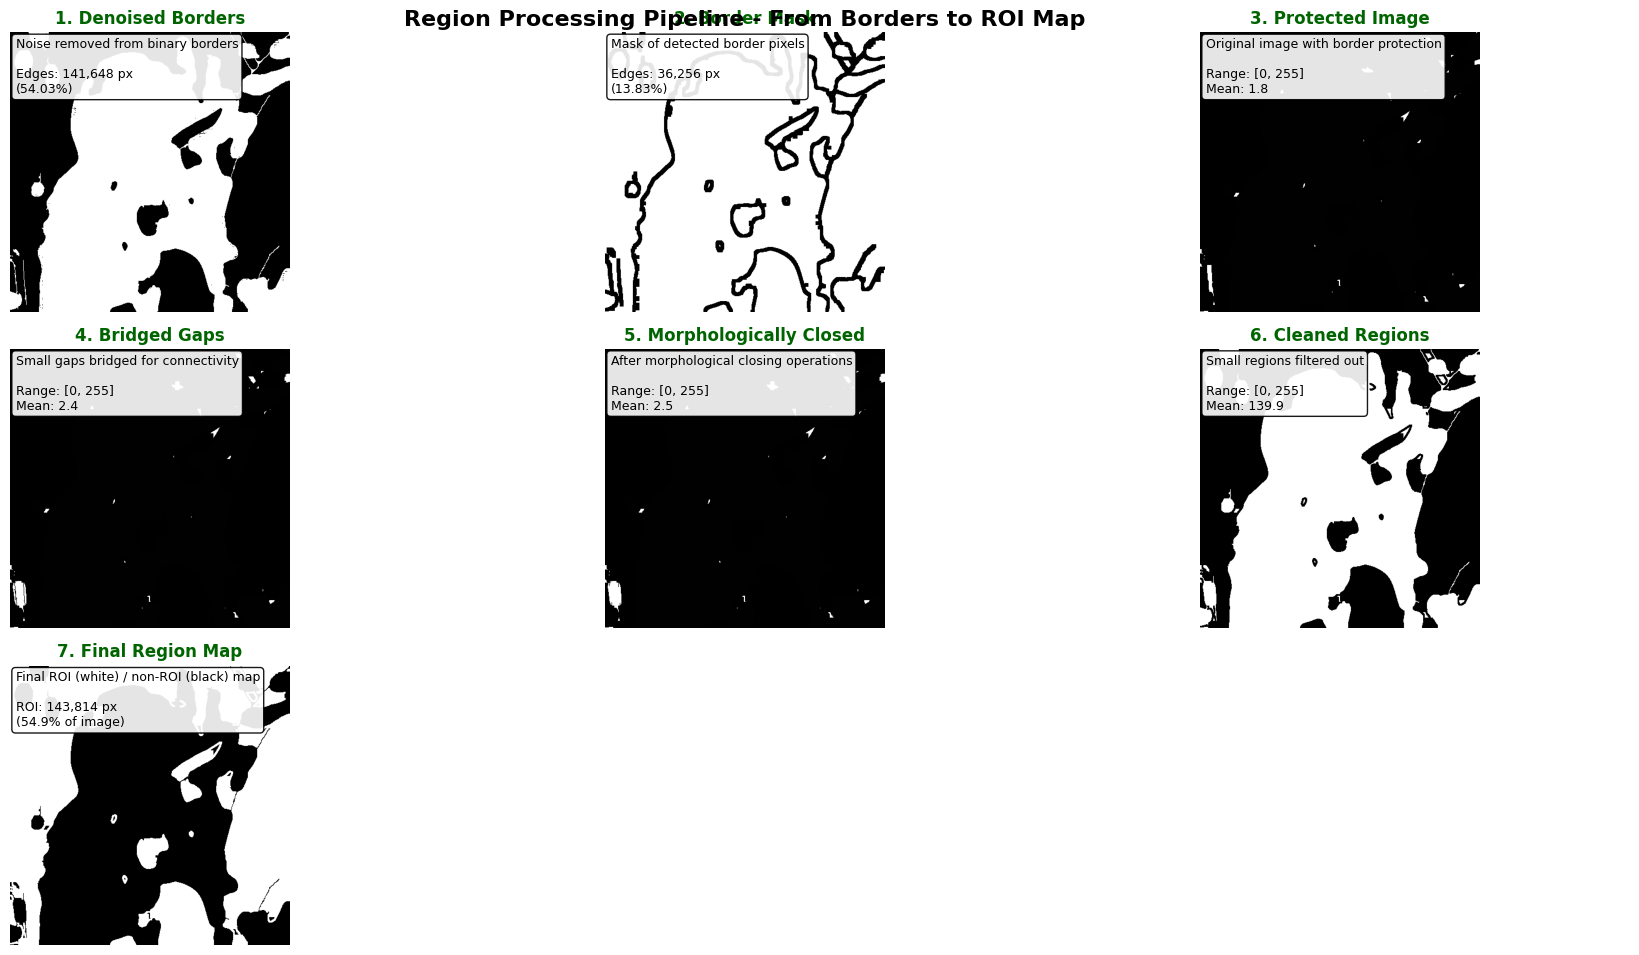

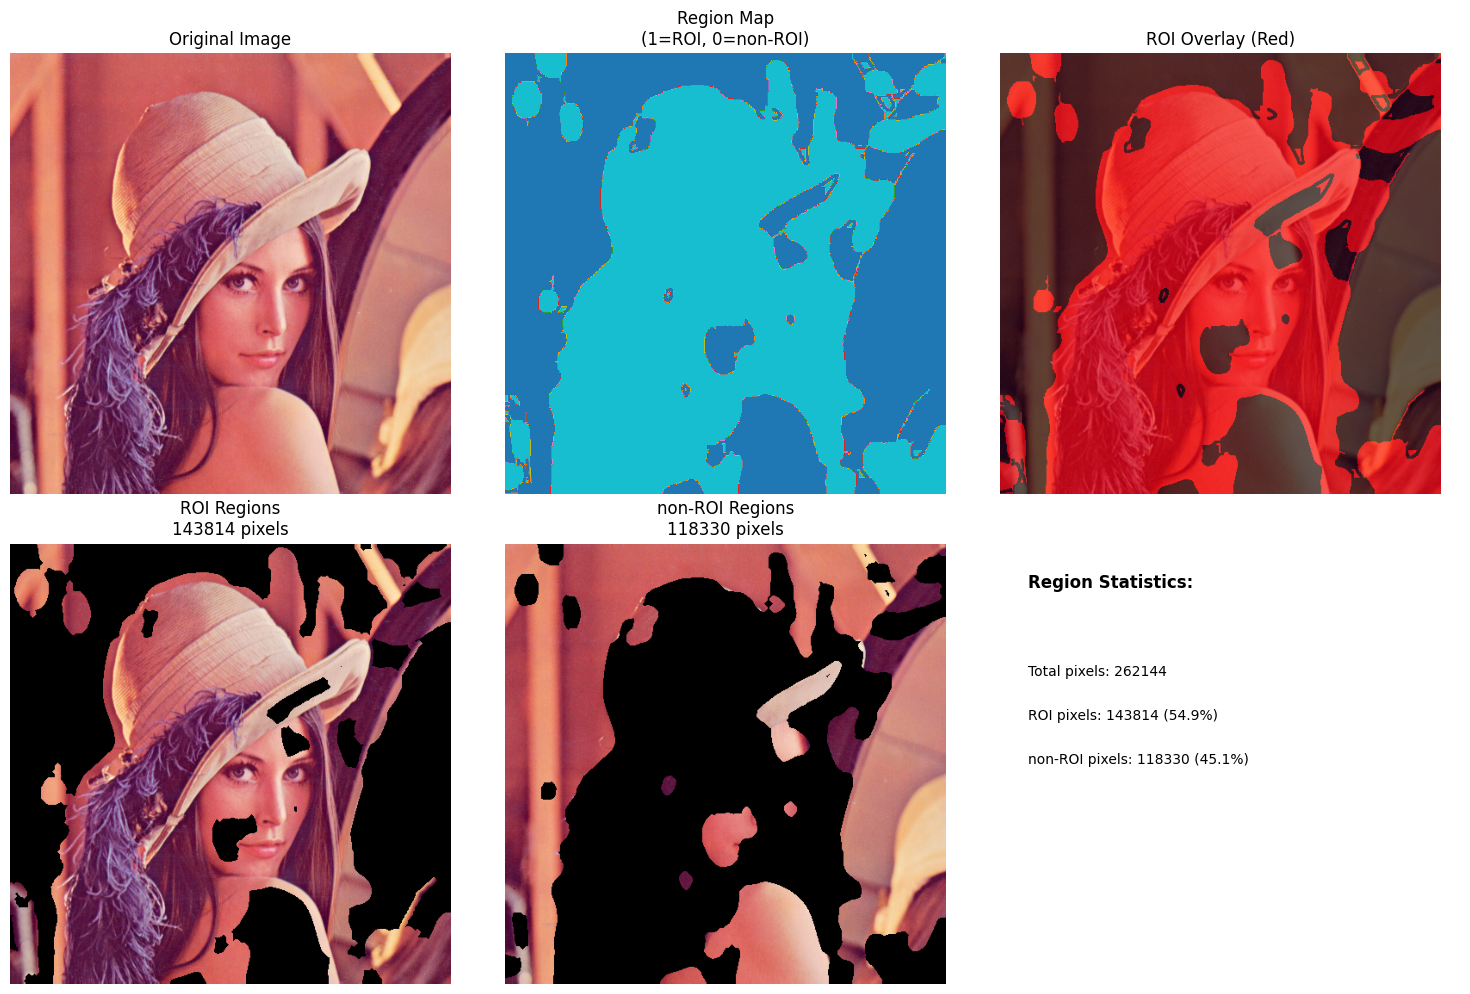

In [14]:

import math
import numpy as np
from encoder.ROI.edges import compute_local_density, suggest_automatic_threshold, get_edge_map
from encoder.ROI.thin_regions2 import remove_thin_structures_optimized
from encoder.ROI.small_regions import remove_small_regions, connect_nearby_pixels, connect_by_closing_fast
from encoder.ROI.small_gaps import bridge_small_gaps, bridge_small_gaps_fast

from encoder.ROI.roi import remove_small_noise_regions, detect_meaningful_borders, protect_border_regions, fill_closed_regions, extract_roi_nonroi,visualize_roi_nonroi_comparison

# Get edge and density maps
edge_map = get_edge_map(image_rgb)
edge_density = compute_local_density(edge_map, kernel_size=3)

# Variables used for ROI Detection
density_threshold = suggest_automatic_threshold(edge_density, edge_map, method="mean") / 100
min_region_size= math.ceil( image_rgb.size / math.pow(10, math.ceil(math.log(image_rgb.size, 10))-3 ) ) 



"""
Complete pipeline: filter edges by density, then unify regions, remove small regions.
Returns ROI and non-ROI separately.
"""

# Get high-density borders
high_density_mask = edge_density > density_threshold
intensity_borders = edge_map.copy()
intensity_borders[~high_density_mask] = 0

# Convert to binary (0 and 255)
binary_borders = (intensity_borders > 0).astype(np.uint8) * 255

# Remove tgin structures and noise from the picture
binary_thin_bordersless=remove_thin_structures_optimized(binary_borders, density_threshold=0.10, thinness_threshold=0.3, window_size=25, min_region_size=25) 
noiseless_binary_borders=remove_small_noise_regions(binary_thin_bordersless, min_size=75)

# Connect Regions Close to each other
pre_connected = connect_by_closing_fast(
    noiseless_binary_borders,
    connection_distance=5,
    min_region_size=25
)
connected = bridge_small_gaps_fast(pre_connected, max_gap=100, density_threshold=0.2, local_window=15, regional_window=25)


plot_border_stages(intensity_borders, binary_borders, 
                   binary_thin_bordersless, noiseless_binary_borders,
                   pre_connected, connected)



"""
Unify regions while respecting natural borders and directional context.
"""

# Ensure binary image is 0-255 uint8
#if connected.max() <= 1:
binary_image = (connected * 255).astype(np.uint8)

denoised=binary_image

# Step 2: Detect strong borders using gradient
border_mask = detect_meaningful_borders(denoised, sensitivity=0.5)

# Step 3: Protect borders from being unified
protected_image = protect_border_regions(denoised, border_mask, kernel_size=15)

# Step 4: Bridge small gaps within regions (not across borders)
bridged_image = bridge_small_gaps_fast(protected_image, max_gap=25, density_threshold=0.2, local_window=15, regional_window=25)

closed_regions=fill_closed_regions(bridged_image, min_hole_size=10, max_hole_size=10000, connectivity=4)

cleaned_image = remove_small_regions(closed_regions, min_size=5, remove_thin_lines=True, kernel_size=30)

# Create region map
region_map = (cleaned_image > 0).astype(np.uint8)

# Usage
plot_region_processing_pipeline(
    denoised, 
    border_mask, 
    protected_image, 
    bridged_image, 
    closed_regions, 
    cleaned_image, 
    region_map
)

# Extract ROI and non-ROI
roi_image, nonroi_image, roi_mask, nonroi_mask = extract_roi_nonroi(image_rgb, region_map)

visualize_roi_nonroi_comparison(image_rgb, roi_image, nonroi_image, region_map)
